In [1]:
import os.path
import tensorflow as tf
import utils.helper
import glob
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from distutils.version import LooseVersion
import csv
from scipy import misc
import time
import os
import numpy as np
import cv2
import pickle
from utils.birdseye import BirdsEye
from utils.lanefilter import LaneFilter
from utils.curves import Curves
from utils.helper import *
from utils.tools import *

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
test_data_path = './data/crops/original/'
imgs = glob(os.path.join(test_data_path, "*.png"))
img = misc.imread(imgs[1])
print(img.shape)  # Print Original Image Size

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(720, 1280, 3)


# Only Run Road Segmentation

INFO:tensorflow:Restoring parameters from ./data\vgg\variables\variables
INFO:tensorflow:Restoring parameters from ./model/model.ckpt
Restored the saved Model in file: ./model/model.ckpt
Predicting images...


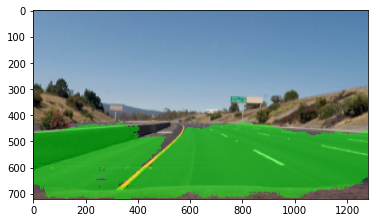

Processing file: 00001,	Speed: 0.49 fps


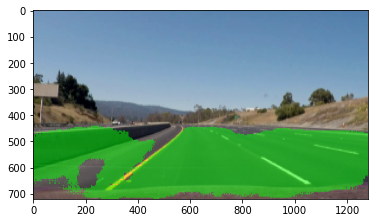

Processing file: 00002,	Speed: 0.49 fps


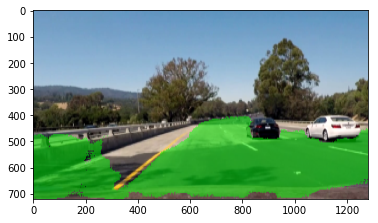

Processing file: 00003,	Speed: 0.49 fps


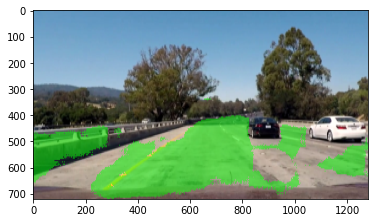

Processing file: 00004,	Speed: 0.50 fps


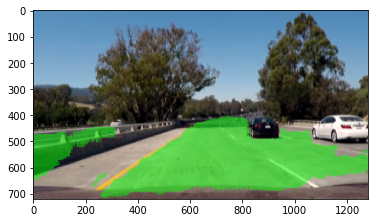

Processing file: 00005,	Speed: 0.49 fps


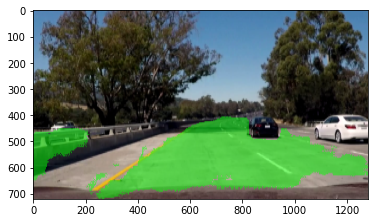

Processing file: 00006,	Speed: 0.49 fps


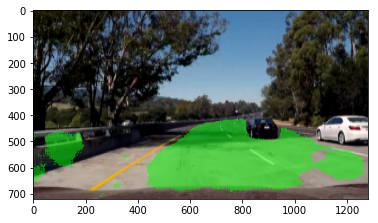

Processing file: 00007,	Speed: 0.49 fps


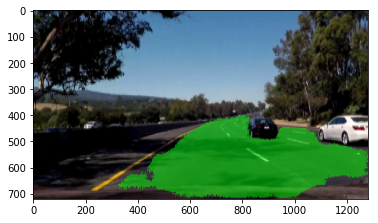

Processing file: 00008,	Speed: 0.49 fps


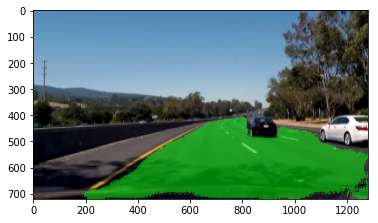

Processing file: 00009,	Speed: 0.49 fps


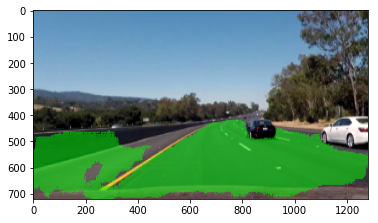

Processing file: 00010,	Speed: 0.49 fps


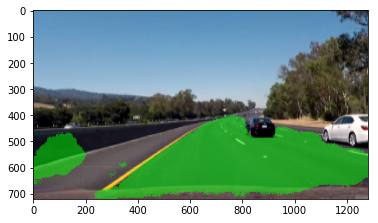

Processing file: 00011,	Speed: 0.49 fps


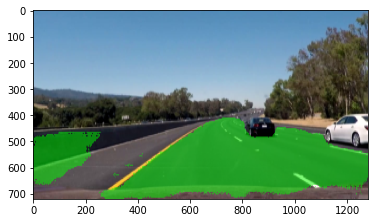

Processing file: 00012,	Speed: 0.49 fps


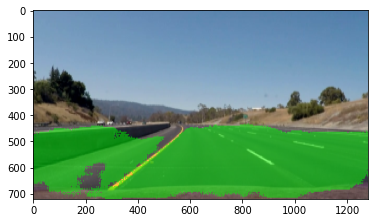

Processing file: 00013,	Speed: 0.49 fps


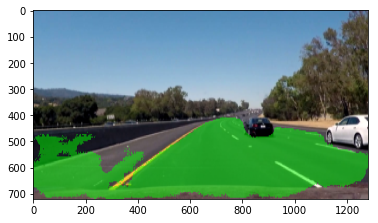

Processing file: 00014,	Speed: 0.49 fps


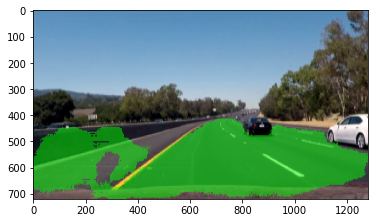

Processing file: 00015,	Speed: 0.49 fps


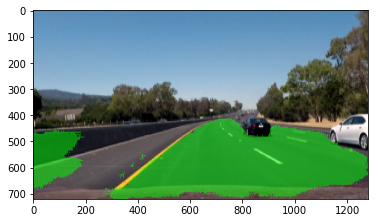

Processing file: 00016,	Speed: 0.49 fps


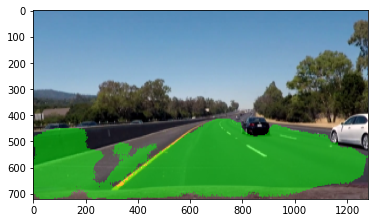

Processing file: 00017,	Speed: 0.48 fps


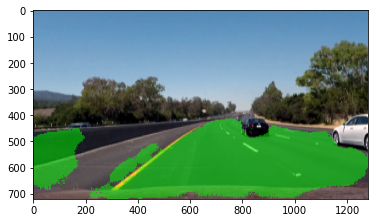

Processing file: 00018,	Speed: 0.49 fps


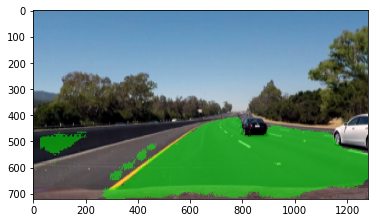

Processing file: 00019,	Speed: 0.46 fps


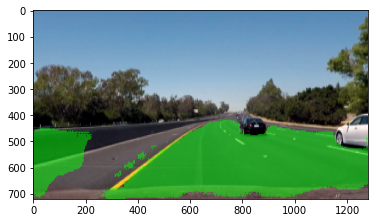

Processing file: 00020,	Speed: 0.47 fps


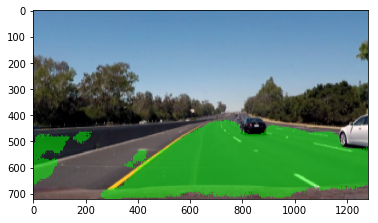

Processing file: 00021,	Speed: 0.47 fps


KeyboardInterrupt: 

In [3]:
if __name__ == '__main__':

    # use the pre-trained model to predict more images
    #test_data_path = './data/data_road/testing/image_2'
    predict_images(test_data_path, print_speed=True, visualize = True)

In [6]:
os.system('python3 monodepth_simple.py --checkpoint_path model/Depth/model_kitti --path ./data/crops/original/')

1

# Initialization

In [3]:
calibration_data = pickle.load(open("calibration_data.p", "rb" ))

matrix = calibration_data['camera_matrix']
distortion_coef = calibration_data['distortion_coefficient']

source_points = [(580, 460), (205, 720), (1110, 720), (703, 460)]
destination_points = [(320, 0), (320, 720), (960, 720), (960, 0)]

p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
      'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }

birdsEye = BirdsEye(source_points, destination_points, matrix, distortion_coef)
laneFilter = LaneFilter(p)
curves = Curves(number_of_windows = 9, margin = 100, minimum_pixels = 50, 
                ym_per_pix = 30 / 720 , xm_per_pix = 3.7 / 700)

# Load Training Models

In [4]:
VGG_LOADING_FLAG = 0

In [5]:
# Path to vgg model
vgg_path = os.path.join('./data', 'vgg')
num_classes = 2
image_shape = (160, 576)
init = tf.global_variables_initializer()
runs_dir = './runs'


sess=tf.Session() 

if not VGG_LOADING_FLAG:
    sess.run(init)
    # Predict the logits
    input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)
    nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    VGG_LOADING_FLAG = 1


# Restore the saved model
saver = tf.train.Saver()
saver.restore(sess, model_path)
    
print("Restored the saved Model in file: %s" % model_path)

INFO:tensorflow:Restoring parameters from ./data\vgg\variables\variables
INFO:tensorflow:Restoring parameters from ./model/model.ckpt
Restored the saved Model in file: ./model/model.ckpt


# PipLine

In [32]:
def pipeline(ground_img):
    
    #ground_img = birdsEye.undistort(img)
    binary = laneFilter.apply(ground_img)
    wb = np.logical_and(birdsEye.sky_view(binary), roi(binary)).astype(np.uint8)
    result = curves.fit(wb)
    ground_img_with_projection = birdsEye.project(ground_img, binary, 
                                    result['pixel_left_best_fit_curve'], result['pixel_right_best_fit_curve'])

    text_pos = "vehicle position: " + result['vehicle_position_words']
    text_l = "left radius: " + str(np.round(result['left_radius'], 2)) 
    text_r = " right radius: " + str(np.round(result['right_radius'], 2))    
    #cv2.putText(ground_img_with_projection, text_l, (20, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
    #cv2.putText(ground_img_with_projection, text_r, (400, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
    #cv2.putText(ground_img_with_projection, text_pos, (20, 80), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
    
    _, road_mask = pred_single(runs_dir, img, sess, image_shape, logits, keep_prob, input_image, print_speed=False,visualize=False)
    
    road_mask = scipy.misc.imresize(road_mask, (720,1280))
    
    # Original IMG + Road Prediction
    midResult = cv2.addWeighted(img, 1, road_mask[:,:,:3], 0.4, 0)
    # Original image + Road Prediction + Line Detection
    results = cv2.addWeighted(midResult, 1, ground_img_with_projection, 0.4, 0)
    
    
    plt.imshow(midResult)
    plt.show()
    plt.imshow(ground_img_with_projection)
    plt.show()

    return results

In [33]:
img = scipy.misc.imread('./data/crops/original/frame16.png')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Predicting images...


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


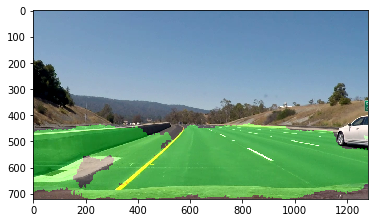

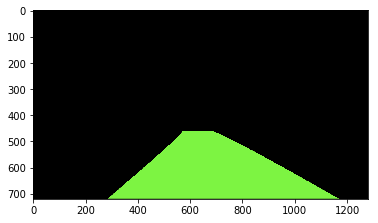

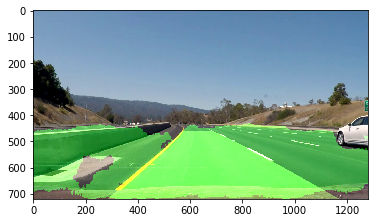

In [34]:
result = pipeline(img)
plt.imshow(result)
plt.show()

# Close Session

In [9]:
sess.close() 